In [3]:
# !conda install -c conda-forge librosa

# !conda install tqdm

In [4]:
import torch as ch
import torch.nn as nn
import torch.functional as F
import numpy as np
import pandas as pd
import scipy as sp
from matplotlib import pyplot as plt
%matplotlib inline

import os
import string
import librosa

import tqdm

In [5]:
ch.cuda.current_device()

0

In [29]:
ch.set_default_tensor_type('torch.cuda.FloatTensor')

In [30]:
import torch.utils.data as Data
import datasets

In [31]:
class C(ch.nn.Module):
    def __init__(self,o,i,k,d,causal,s=1):
        super(C,self).__init__()
        self.causal = causal
        assert (k-1)%2 == 0 
        if causal:
            self.pad = (k-1)*d
        else:
#             print('filter',k,'dilation',d,'total pad',(k-1)*d,'half pad',(k-1)*d//2)
            self.pad = (k-1)*d // 2 
        self.conv = ch.nn.Conv1d(out_channels=o, in_channels=i,
                    kernel_size=k, dilation=d, stride=s, padding=self.pad)
        ch.nn.init.kaiming_normal_(self.conv.weight.data)
        self.dilation = d
    
    def forward(self,X):
        O = self.conv(X)
        return O[:,:,:-self.pad] if self.causal and self.pad else O

In [32]:
class Cs(ch.nn.Module):
    def __init__(self,o,i,k,d,causal,s=1):
        super(C,self).__init__()
        self.causal = causal
        assert (k-1)%2 == 0 
        if causal:
            self.pad = (k-1)*d
        else:
            self.pad = (k-1)*d // 2 
#         self.conv = ch.nn.Conv1d(out_channels=o, in_channels=i,
#                     kernel_size=k, dilation=d, stride=s, padding=pad)
        self.depthwise = ch.nn.Conv1d(out_channels=i, in_channels=i,
                        kernel_size=k, dilation=d, stride=s,
                        padding=self.pad, groups=i)
        self.pointwise = ch.nn.Conv1d(out_channels=o, in_channels=i,kernel_size=1)
        ch.nn.init.kaiming_normal_(self.depthwise.weight.data)
        ch.nn.init.kaiming_normal_(self.pointwise.weight.data)
    
    def forward(self,X):
        O = self.pointwise(self.depthwise(X))
        return O[:,:,:-self.pad] if self.causal else O

In [33]:
class Css(ch.nn.Module):
    def __init__(self,o,i,k,d,causal,s=1):
        super(C,self).__init__()
        self.causal = causal
        assert (k-1)%2 == 0 
        if causal:
            self.pad = (k-1)*d
        else:
            self.pad = (k-1)*d // 2 
#         self.conv = ch.nn.Conv1d(out_channels=o, in_channels=i,
#                     kernel_size=k, dilation=d, stride=s, padding=pad)
        self.depthwise = ch.nn.Conv1d(out_channels=i, in_channels=i,
                        kernel_size=k, dilation=d, stride=s,
                        padding=self.pad, groups=i)
        self.pointwise = ch.nn.Conv1d(out_channels=o, in_channels=i,
                                      kernel_size=1, groups=4)
        ch.nn.init.kaiming_normal_(self.depthwise.weight.data)
        ch.nn.init.kaiming_normal_(self.pointwise.weight.data)
    
    def forward(self,X):
        O = self.pointwise(self.depthwise(X))
        return O[:,:,:-self.pad] if self.causal else O

In [34]:
conv = C(8,4,3,1,0)
conv(ch.rand(3,4,10)).shape

torch.Size([3, 8, 10])

In [35]:
class D(ch.nn.Module):
    def __init__(self,o,i,k,d,causal=0,s=2):
        super(D,self).__init__()
        self.tconv = ch.nn.ConvTranspose1d(out_channels=o, in_channels=i, 
                       kernel_size=k, dilation=d, stride=s)
        ch.nn.init.kaiming_normal_(self.tconv.weight.data)
    
    def forward(self,X):
        return self.tconv(X)

In [36]:
class HC(ch.nn.Module):
    def __init__(self,o,i,k,d,causal,s=1):
        assert o == i
        super(HC,self).__init__()
        self.o = o
        self.conv = C(2*o,i,k,d,causal,s)

    def forward(self,X):
        H = self.conv(X)
        H1,H2 = H[:,:self.o,:],H[:,self.o:,:]
        G = ch.sigmoid(H1)
        return G*H2 + (1-G)*X

In [37]:
class TextEnc(ch.nn.Module):
    def __init__(self,d,e,c2i):
        super(TextEnc,self).__init__()
        c = 0 # non causal
        self.embed = ch.nn.Embedding(len(c2i),e)
        ch.nn.init.kaiming_normal_(self.embed.weight.data)
        layers = [C(2*d,e,1,1,c),ch.nn.ReLU(),C(2*d,2*d,1,1,c)]
        for _ in range(2):
            layers += [HC(2*d,2*d,3,3**ldf,c) for ldf in range(4)]
        layers += [HC(2*d,2*d,3,1,c) for _ in range(2)]
        layers += [HC(2*d,2*d,1,1,c) for _ in range(2)]
        self.seq = ch.nn.Sequential(*layers)
    
    def forward(self,L):
        # permute b/c next layer expects dims to be [batch,embed,seq]
        # output of embed layer is [batch,seq,embed]
#         print(L.shape,self.embed(L).shape)
#         print(self.embed(L).permute(0,2,1).shape)
        return self.seq(self.embed(L).permute(0,2,1))

In [38]:
class AudioEnc(ch.nn.Module):
    def __init__(self,d,F):
        super(AudioEnc,self).__init__()
        c = 1 # causal
        layers = [C(d,F,1,1,c),ch.nn.ReLU(),C(d,d,1,1,c),ch.nn.ReLU(),C(d,d,1,1,c)]
        for _ in range(2):
            layers += [HC(d,d,3,3**ldf,c) for ldf in range(4)]
        layers += [HC(d,d,3,3,c) for _ in range(2)]
        self.seq = ch.nn.Sequential(*layers)
        
    def forward(self,S):
        return self.seq(S)

In [39]:
class Text2Mel(ch.nn.Module):
    def __init__(self,d,e,c2i,F):
        super(Text2Mel,self).__init__()
        self.d = d
        self.textEnc = TextEnc(d,e,c2i)
        self.audioEnc = AudioEnc(d,F)
    
    def forward(self,L,S):
        KV = self.textEnc(L)
        K,V = KV[:,:self.d,:],KV[:,self.d:,:]
        Q = self.audioEnc(S[:,:,:])
#         print('K',K.shape,'V',V.shape,'Q',Q.shape)
        A = ch.nn.Softmax(dim=1)(ch.matmul(ch.transpose(K,-1,-2),Q) / self.d**0.5)
        R = ch.matmul(V,A)
#         print('R',R.shape,'Q',Q.shape)
        return ch.cat([R,Q],dim=1),A

In [40]:
class AudioDec(ch.nn.Module):
    def __init__(self,d,F):
        super(AudioDec,self).__init__()
        s = 1 # causal
        layers = [C(d,2*d,1,1,s)]
        for _ in range(1): #?
            layers += [HC(d,d,3,3**ldf,s) for ldf in range(4)]
        layers += [HC(d,d,3,1,s) for _ in range(2)]
        for _ in range(3): 
            layers += [C(d,d,1,1,s),ch.nn.ReLU()]
        layers += [C(F,d,1,1,s),ch.nn.Sigmoid()]
        self.seq = ch.nn.Sequential(*layers)
    
    def forward(self,Rp):
        return self.seq(Rp)

In [41]:
class SSRN(ch.nn.Module):
    def __init__(self,c,F,Fp):
        super(SSRN,self).__init__()
        s = 0 # non causal
        layers = [C(c,F,1,1,s)]
        for _ in range(1): #?
            layers += [HC(c,c,3,1,s),HC(c,c,3,3,s)]
        for _ in range(2):
            layers += [D(c,c,2,1),HC(c,c,3,1,s),HC(c,c,3,3,s)]
        layers += [C(2*c,c,1,1,s)]
        layers += [HC(2*c,2*c,3,1,s) for _ in range(2)]
        layers += [C(Fp,2*c,1,1,s)]
        for _ in range(2):
            layers += [C(Fp,Fp,1,1,s),ch.nn.ReLU()]
        layers += [C(Fp,Fp,1,1,s),ch.nn.Sigmoid()]
        self.seq = ch.nn.Sequential(*layers)
    
    def forward(self,Y):
        return self.seq(Y)

In [42]:
# conv = C(3,2,3,1,0)
# tconv = D(3,2,2,1,2)
# hconv = HC(2,2,3,1,0)
# I.shape,conv(I).shape,tconv(I).shape,hconv(I).shape

In [43]:
d = 256;e=128;c2i=[0]*26;c=512;F=80;Fp=513
# Fp = 516
alpha = 0.5
d=int(d*alpha); e=int(e*alpha); c=int(c*alpha)
textEnc = TextEnc(d=d,e=e,c2i=c2i)
audioEnc = AudioEnc(d=d,F=F)
audioDec = AudioDec(d=d,F=F)
ssrn = SSRN(c=c,F=F,Fp=Fp)
text2Mel = Text2Mel(d=d,e=e,c2i=datasets.LJSpeechDataset().alpha,F=F)

In [45]:
# text2Mel.cuda()
# audioDec.cuda()
# ssrn.cuda()

In [46]:
# alpha = 0.5, super-separable
[sum(np.prod(p.size()) for p in m.parameters()) for m in (textEnc,audioEnc,audioDec,ssrn,text2Mel)]

[4284544, 1028992, 684112, 6979335, 5313856]

In [47]:
class DbinLoss(ch.nn.Module):
    def __init__(self):
        super(DbinLoss,self).__init__()
    
    def forward(self,Yhat,Y):
        EPS = 1e-12
        elLoss = -(Y*ch.log(Yhat+EPS)+(1-Y)*ch.log(1-Yhat+EPS))
#         return elLoss.view(elLoss.shape[0],-1).mean(1)
        return elLoss.mean()

In [48]:
class GAttLoss(ch.nn.Module):
    def __init__(self):
        super(GAttLoss,self).__init__()
            
    def forward(self,A):
        _,N,T = A.shape
        W = ch.Tensor([[np.e**(-(n/N-t/T)**2 / (2*g**2)) 
                        for t in range(1,T+1)] 
                       for n in range(1,N+1)])
        return ((1-W)*A).mean()

In [49]:
L1Fun = ch.nn.L1Loss()
BCEFun = ch.nn.BCELoss()
def MelFun(Shat,S): return L1Fun(Shat,S) + BCEFun(Shat,S)
DbinFun = DbinLoss()
GAttFun = GAttLoss()

In [50]:
lr = 2e-4
init_lr=2e-4
g=0.2
b1 = 0.5
b2 = 0.9
eps = 1e-6
logevery = 200
dropout_rate = 0.1
masking = False

In [89]:
dtype = ch.FloatTensor
# dtype = ch.cuda.FloatTensor # Uncomment this to run on GPU

In [101]:
# import torch
ch.multiprocessing.set_start_method("spawn",force=True)

In [112]:
import datasets
from importlib import reload
reload(datasets)

text2MelLoader = Data.DataLoader(datasets.LJSpeechDataset(ttmel=1),
                                 batch_size=16,
                                 shuffle=True,
                                 num_workers=8)
ttMelOpt = ch.optim.Adam(set(text2Mel.parameters())|set(audioDec.parameters()),
                          lr=lr,betas=(b1,b2),eps=eps)

step 669 total 0.020737335085868835 mel 0.020586784929037094 att 0.0001505499822087586


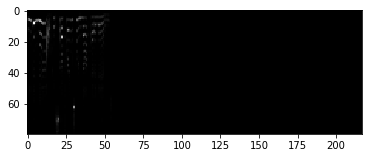

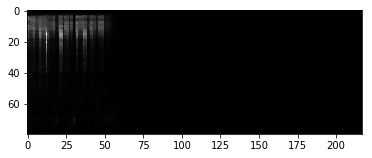

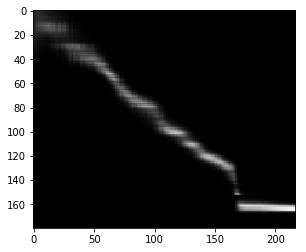

In [ ]:
for epoch in range(10):
    for step,(batchL,batchS,_) in tqdm.tqdm_notebook(enumerate(text2MelLoader)):
        batchL = batchL.cuda()
        batchS = batchS.cuda()
        bL = ch.autograd.Variable(batchL)
        bS = ch.autograd.Variable(batchS)
        Rp,A = text2Mel(bL,bS)
        Shat = audioDec(Rp)
        melloss = MelFun(Shat[:,:,:-1],bS[:,:,1:])
        attloss = GAttFun(A)
        loss = melloss + attloss
        ttMelOpt.zero_grad()
        loss.backward()
        ttMelOpt.step()
#         if step % 100 == 0: 
#             print('step',step,'total',loss.data.item(),
#                   'mel',melloss.data.item(),'att',attloss.data.item())
#         if step % 100 == 0:
#             plt.imshow(bS[0].cpu().detach().numpy(),cmap='gray')
#             plt.show()
#             plt.imshow(Shat[0].cpu().detach().numpy(),cmap='gray')
#             plt.show()
#             plt.imshow(A[0].cpu().detach().numpy(),cmap='gray')
#             plt.show()
    print('step',step,'total',loss.data.item(),
          'mel',melloss.data.item(),'att',attloss.data.item())
    plt.imshow(bS[0].cpu().detach().numpy(),cmap='gray')
    plt.show()
    plt.imshow(Shat[0].cpu().detach().numpy(),cmap='gray')
    plt.show()
    plt.imshow(A[0].cpu().detach().numpy(),cmap='gray')
    plt.show()

In [ ]:
import datasets
from importlib import reload
reload(datasets)

ssrnLoader = Data.DataLoader(datasets.LJSpeechDataset(ttmel=0),
                             batch_size=16,
                             shuffle=True,
                             num_workers=8)
ssrnOpt = ch.optim.Adam(ssrn.parameters(),lr=lr,betas=(b1,b2),eps=eps)

In [ ]:
for epoch in range(10):
    for step,(_,batchS,batchY) in tqdm.tqdm_notebook(enumerate(ssrnLoader)):
        batchS = batchS.cuda()
        batchY = batchY.cuda()
        bS = ch.autograd.Variable(batchS)
        bY = ch.autograd.Variable(batchY)
        Yhat = ssrn(bS)
        loss = MelFun(Yhat,bY)
        ssrnOpt.zero_grad()
        loss.backward()
        ssrnOpt.step()
#         if step % 100 == 0: 
#             print('step',step,'loss',loss.data.item())
#         if step % 100 == 0:
#             plt.imshow(bS[0].cpu().detach().numpy(),cmap='gray')
#             plt.show()
#             plt.imshow(bY[0].cpu().detach().numpy(),cmap='gray')
#             plt.show()
#             plt.imshow(Yhat[0].cpu().detach().numpy(),cmap='gray')
#             plt.show()
    print('step',step,'loss',loss.data.item())
    plt.imshow(bS[0].cpu().detach().numpy(),cmap='gray')
    plt.show()
    plt.imshow(bY[0].cpu().detach().numpy(),cmap='gray')
    plt.show()
    plt.imshow(Yhat[0].cpu().detach().numpy(),cmap='gray')
    plt.show()

In [235]:
C(1,2,3,4,0)

C(
  (conv): Conv1d(2, 1, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
)

In [282]:
tensor(0.4850, grad_fn=<L1LossBackward>)
tensor(0.4834, grad_fn=<L1LossBackward>)
tensor(0.4792, grad_fn=<L1LossBackward>)
tensor(0.4764, grad_fn=<L1LossBackward>)

SyntaxError: invalid syntax (<ipython-input-282-960c27f0bd3e>, line 1)